# I could not get the right lane in my earlier tests. Hence I will re-do everything in a more structured way by defining most needed functions first and then proceed.

In [1]:
import numpy as np
import cv2
import os
import pickle
import matplotlib.pyplot as plt
calib_data = pickle.load( open("camera_cal/wide_dist_pickle.p", "rb" ) )
dist = calib_data['dist']
mtx = calib_data['mtx']

In [2]:
dist

array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
         -1.28318543e-04,   2.67124302e-02]])

In [3]:
mtx

array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
       [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

### Now create all the functions (Distortion Correction, Sobel Edge dection and perspective wapr together to process the entire data.

In [4]:
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def warp_image(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def color_mask(hsv,low,high): 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

### I will load only one image and proceed with that now.

#### in order to avoid the conversion from BGR2RGB, I am using mpimg read in this case.

#### I am loading the undistorted image saved from my earlier experiments.

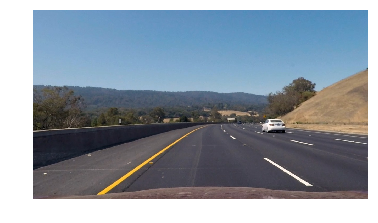

In [99]:
%matplotlib inline
import matplotlib.image as mpimg
image = mpimg.imread('test_images/undist_test3.jpg')
plt.imshow(image);
plt.axis('off');

###  I am applying perspective transform first.

In [100]:
image_size = image.shape
image_size

(720, 1280, 3)

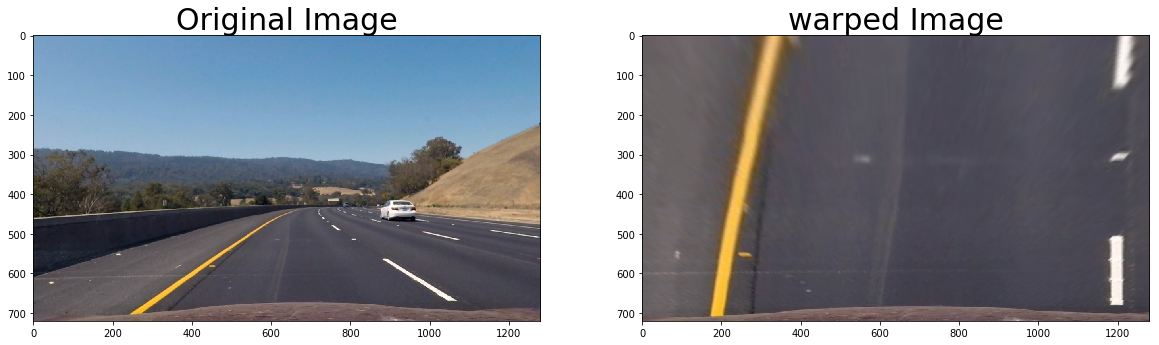

In [101]:
ht_window = np.uint(image_size[0]/1.5)
hb_window = np.uint(image_size[0])
c_window = np.uint(image_size[1]/2)
ctl_window = c_window - .2*np.uint(image_size[1]/2)
ctr_window = c_window + .2*np.uint(image_size[1]/2)
cbl_window = c_window - .9*np.uint(image_size[1]/2)
cbr_window = c_window + .9*np.uint(image_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],
                  [image_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(image_size[1],image_size[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped, cmap = 'gray')
ax2.set_title('warped Image',fontsize=30)

### Applying yellow Color Mask

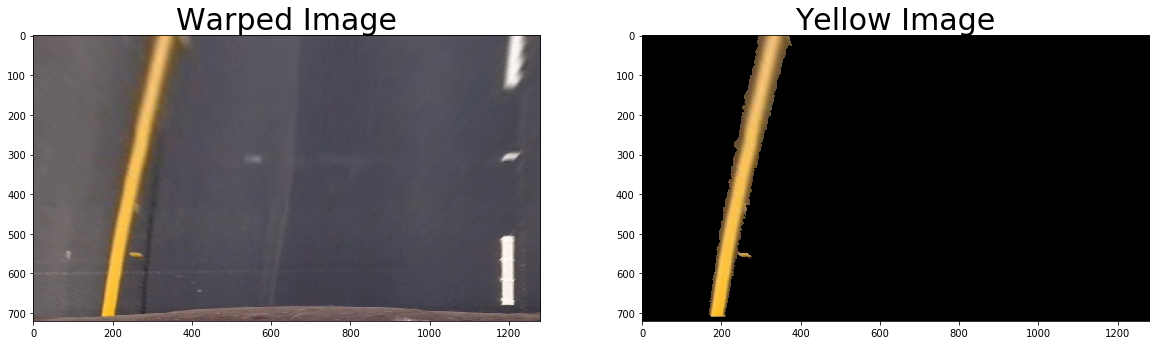

In [102]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])


yellow_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)

yellow = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(yellow, cmap = 'gray')
ax2.set_title('Yellow Image',fontsize=30)

### Applying White color mask

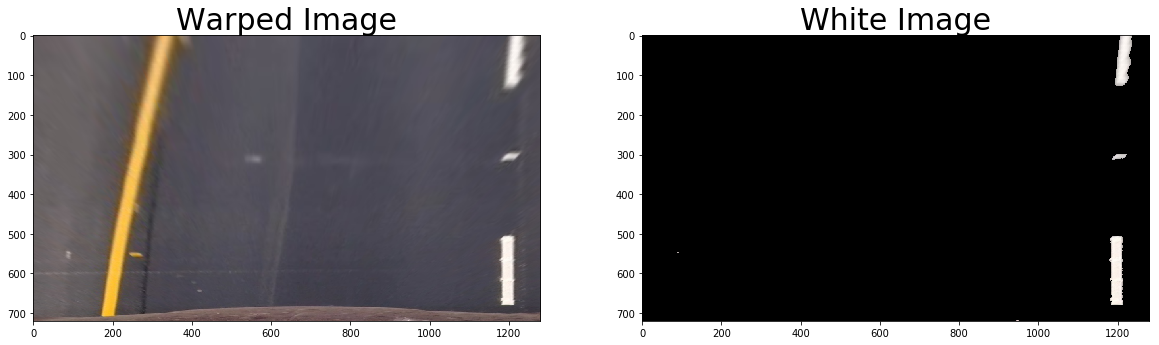

In [103]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)


white_hsv_low  = np.array([ 0,   0,   175])
white_hsv_high = np.array([ 255,  30, 255])

white = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(white, cmap = 'gray')
ax2.set_title('White Image',fontsize=30)

### Combine both the color masks

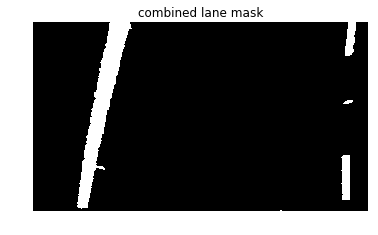

In [104]:
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask')
plt.axis('off');

### Applying SOBEL filter

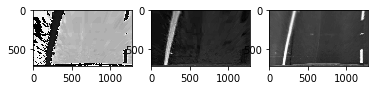

In [105]:
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

### Applying SOBEL filter to L and S channels

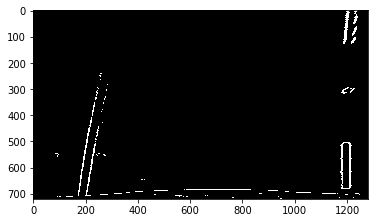

In [106]:
imageL = cv2.GaussianBlur(image,(5,5),0)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

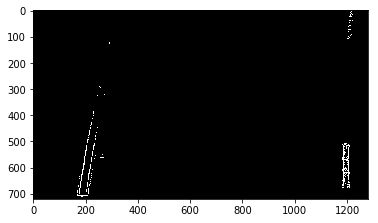

In [107]:
img_gs = image_HLS[:,:,2]
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

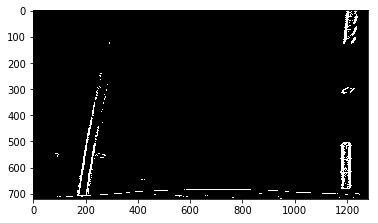

In [108]:
combined_image = cv2.bitwise_or(wraped2,wraped3)
plt.imshow(combined_image,cmap='gray')

### combine color mask and sobel filter

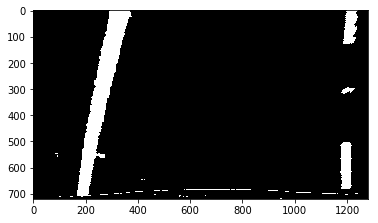

In [109]:
combined_image1 = np.zeros_like(combined_image)
combined_image1[(mask_lane>=.5)|(combined_image>=.5)]=1
combined_image1 = cv2.GaussianBlur(combined_image1,(3,3),0)
plt.imshow(combined_image1,cmap='gray')

### Now, I will separate the lanes by looking at the intensities distribution.

C:\Users\Jyoti\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


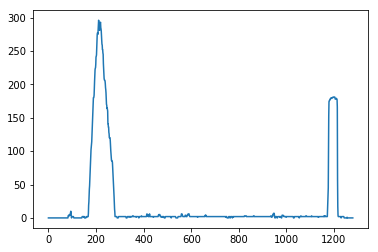

In [110]:
import numpy as np
histogram = np.sum(combined_image1[combined_image1.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [111]:
out_img = np.dstack((combined_image1, combined_image1, combined_image1))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [112]:
nwindows = 7
window_height = np.int(combined_image1.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = combined_image1.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = combined_image1.shape[0] - (window+1)*window_height
    win_y_high = combined_image1.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


(720, 0)

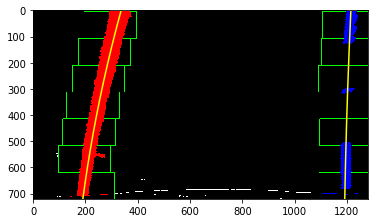

In [113]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, combined_image1.shape[0]-1, combined_image1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [115]:
nonzero = combined_image1.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, combined_image1.shape[0]-1, combined_image1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

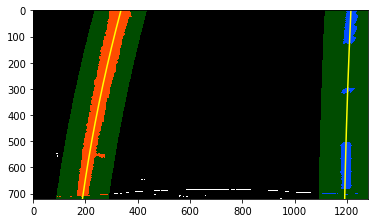

In [116]:
out_img = np.dstack((combined_image1, combined_image1, combined_image1))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

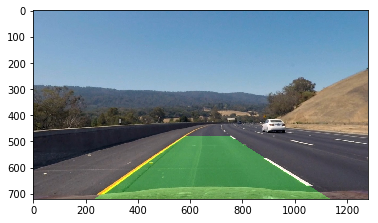

In [122]:
warp_zero = np.zeros_like(combined_image1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

1746.51224994 1529.14526913


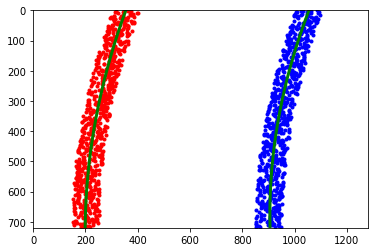

In [123]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)